In [108]:
# Program for analyzing some of my facebook conversations
import numpy as np
import pandas as pd
import os
import json
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

path = 'D:\\Python\\fb convo analysis'
os.chdir(path)

In [109]:
# Function that gets json from directory
def get_message(query):
    message_path = os.path.join(path, 'facebook-shawnliu90\messages\inbox')
    # Searching through message_path for query
    message_folder = os.listdir(message_path)
    # Combining message path with the file name
    message_file = os.path.join(message_path, 
                list(filter(lambda x: query in x, message_folder))[0], 
                'message_1.json')
    with open(message_file, 'r') as json_file:  
        file = json.load(json_file)
    return file

In [110]:
# Function that formats the message for word cloud
def format_message(messages):
    message_string = ''
    for content in messages['messages']:
        if 'content' in content.keys():
            message_string = message_string + ' ' + content['content']
    message_string = message_string.rstrip().lstrip()
    return message_string

In [111]:
# Removing junk words by adding to stopwords
junk_words = {'lol', 'yeah', 'okay', 'thank', 'thanks', 'you', 'man'
              'go', 'think', 'oh', 'ok','that', 'thats', 'yo', 'ya','bro'}

for word in junk_words:
    STOPWORDS.add(word)

# Wordcloud function
def create_wordcloud(text):
    # Mask image for the shape of the cloud
    mask = np.array(Image.open(os.path.join(path, 'mask.png')))
    # Filtering out stopwords like the, and, is, etc.
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white',
                  mask=mask,
                  max_words=200,
                  stopwords=stopwords)
    # Generating the wordcloud and saving it to wordcloud.png in path 
    wc.generate(text)
    wc.to_file(os.path.join(path, 'fb_wordcloud.png'))

In [113]:
# TBD more complicated stuff
def context_analysis(text):
    ''' 
    using spacy and other nlp libraries to do some more advanced analysis 
    - context
    - named entities
    - similar conversations between different people
    '''

In [120]:
# Main for creating wordcloud
main_text = get_message('AlysaaCoco')
main_text_message = format_message(main_text).lower()
create_wordcloud(main_text_message)

In [121]:
# MAKE INTO SEPARATE FUNCTION
# Parsing the dictionary into a dataframe for analysis
main_text_df = pd.DataFrame.from_dict(main_text['messages'])

# Grabbing the timestamp, sender, content, and type
main_text_df = main_text_df[['sender_name', 'timestamp_ms', 'content', 'type']]

In [122]:
# MAKE INTO SEPARATE FUNCTION
# Converting timestamps into dates, first by dividing out the milliseconds in the timestamps
main_text_df['timestamp_ms'] = main_text_df['timestamp_ms']//1000

# Iterating and appending onto a list, then replacing the column with the list
convert_list = []
for timestamp in main_text_df['timestamp_ms']:
    timestamp = datetime.fromtimestamp(timestamp)
    convert_list.append(timestamp)
    
main_text_df['timestamp_ms'] = convert_list

In [123]:
# Creating Shawn and non-Shawn message count column
main_text_df['shawn_msg_count'] = np.where(main_text_df['sender_name'] == 'Shawn Liu', 1, 0)
main_text_df['other_msg_count'] = np.where(main_text_df['sender_name'] != 'Shawn Liu', 1, 0)

In [124]:
# Grouping msg_counts by day
main_text_df_count = main_text_df.groupby(main_text_df['timestamp_ms'].dt.normalize()).sum()
main_text_df_count.head()

,shawn_msg_count,other_msg_count
timestamp_ms,,
2017-01-22,7,12
2017-01-23,5,4
2017-01-24,4,5
2017-02-05,3,2
2017-02-28,0,2


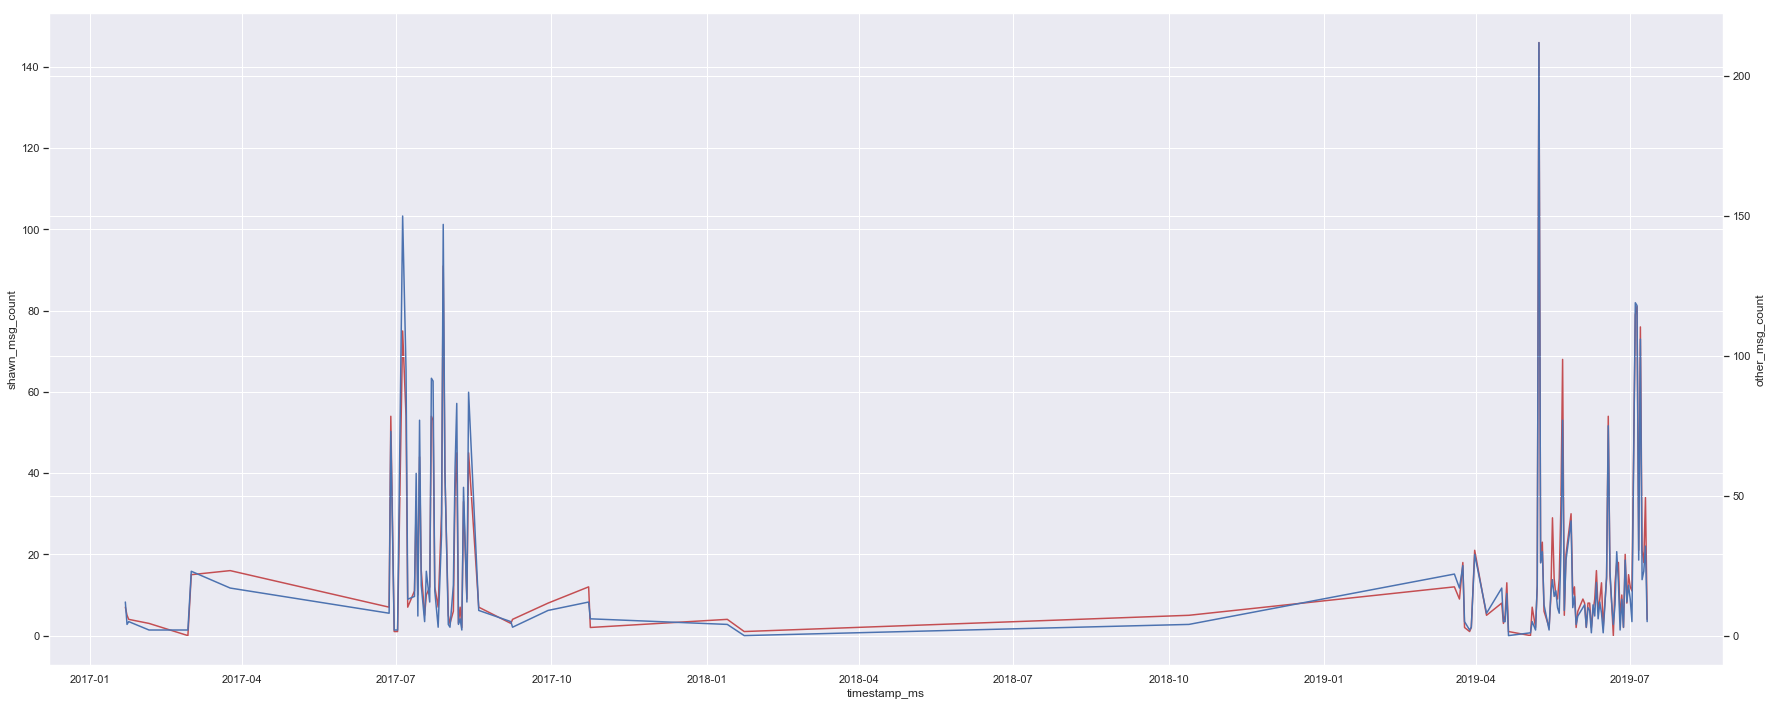

In [125]:
# Plotting -- Need to clean up the graph
sns.set()
plt.figure(figsize=(30, 12))
sns.lineplot(data = main_text_df_count.reset_index(), x = 'timestamp_ms', y = 'shawn_msg_count', color = 'r')

ax2 = plt.twinx()
sns.lineplot(data = main_text_df_count.reset_index(), x = 'timestamp_ms', y = 'other_msg_count', ax = ax2)